In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../utilities')
from basic_utilities import *
from model_utilities import *
from pandas.plotting import scatter_matrix
from ml_utilities import *
import scipy.stats as stats
import pdb
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pickle
sys.path.append('../Data_prep')
from data_config import *
sys.path.append('../../../../infrastructure/tools')
from feature_engineering import feature_engineering
from utilities import utilities
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pdb
from statsmodels.gam.api import GLMGam, BSplines

In [2]:
train_sample = pd.read_csv('../../../data/processed_data/train_sample_segment0_logit.csv')

In [3]:
train_sample.shape

(23973, 135)

In [4]:
get_knots = read_yaml_file('../Data_prep/1d_knots_segment0.yaml')['get_knots']

In [5]:
knots_vars = []
for var in get_knots:
    matching_strings = [s for s in train_sample.columns.tolist() if re.search(f"{var}_", s)]
    knots_vars += matching_strings

In [6]:
get_dummy = read_yaml_file('../Data_prep/dummy_grouping_segment0_draft.yaml')['get_dummies']

In [7]:
dummy_vars = []
for var in get_dummy:
    matching_strings = [s for s in train_sample.columns.tolist() if re.search(f"{var}_", s)]
    dummy_vars += matching_strings

In [8]:
binning_features = read_yaml_file('../Data_prep/binning_features_segment0.yaml')['binning_features']

In [9]:
binning_features = [f.split(',')[0] for f in binning_features]

In [10]:
bin_vars = []
for var in binning_features:
    matching_strings = [s for s in train_sample.columns.tolist() if re.search(f"{var}_bin_", s)]
    bin_vars += matching_strings

In [11]:
bin_vars

['bank_branch_count_8w_bin_1',
 'bank_branch_count_8w_bin_nan',
 'days_since_request_bin_1',
 'days_since_request_bin_nan',
 'session_length_in_minutes_bin_1',
 'session_length_in_minutes_bin_2',
 'session_length_in_minutes_bin_nan']

In [12]:
spec1 = knots_vars + dummy_vars + bin_vars
spec1 = sorted(list(set(spec1)))

In [13]:
Xtrain = train_sample[spec1].astype('float')
ytrain = train_sample['fraud_bool']
weights = train_sample['sample_weight']

In [14]:
glm = sm.GLM(ytrain, Xtrain, family=sm.families.Binomial(), var_weights=weights)
model1 = glm.fit()
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                23973
Model:                            GLM   Df Residuals:                    23928
Model Family:                Binomial   Df Model:                           44
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14282.
Date:                Fri, 20 Jun 2025   Deviance:                       28563.
Time:                        15:01:33   Pearson chi2:                 1.94e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2694
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [15]:
model2 = model1
while True:
    res = utilities.get_beta_n_pvalues(model2)
    spec = list(res['feature'].values)
    newspec = sorted(res.loc[(pd.notna(res['p-values'])) & (res['p-values']<0.05),'feature'])
    if len(newspec) == len(spec):
        break
    else:
        glm = sm.GLM(ytrain, Xtrain[newspec], family=sm.families.Binomial(), var_weights=weights)
        model2 = glm.fit()

In [16]:
model2_spec = newspec

In [17]:
utilities.get_beta_n_pvalues(model2)

,feature,coef,abs_coef,p-values
20,name_email_similarity_2,2.474962,2.474962,1.209563e-07
19,name_email_similarity_1,-2.253001,2.253001,6.576633e-65
21,name_email_similarity_3,-2.191540,2.191540,1.048572e-05
14,housing_status_0,-1.569742,1.569742,2.333244e-49
7,device_distinct_emails_8w_0,1.424414,1.424414,5.136675e-94
18,income_2,1.349201,1.349201,3.112199e-57
8,device_os_0,1.184045,1.184045,2.039565e-191
11,employment_status_3,-1.078558,1.078558,6.233653e-06
16,housing_status_4,-1.077380,1.077380,3.450356e-75
15,housing_status_2,-0.893357,0.893357,6.500122e-67


In [18]:
print(model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                23973
Model:                            GLM   Df Residuals:                    23944
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14297.
Date:                Fri, 20 Jun 2025   Deviance:                       28594.
Time:                        15:01:33   Pearson chi2:                 1.95e+05
No. Iterations:                    22   Pseudo R-squ. (CS):             0.2685
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
bank

In [19]:
#spec3

In [20]:
predictions =  model2.predict(Xtrain[model2_spec])

In [21]:
ans = feature_engineering.f_select_interaction_reg(train_sample, model2_spec, 'fraud_bool', mtype='classification', sample_weight=weights,
                                            interaction_only=True, kbest = 20, order=2, offset = np.log(predictions/(1-predictions)))

In [22]:
ans.feature.tolist()

['device_os_2*housing_status_0',
 'employment_status_5*name_email_similarity_3',
 'employment_status_4*name_email_similarity_3',
 'device_os_2*name_email_similarity_2',
 'employment_status_5*name_email_similarity_2',
 'housing_status_0*name_email_similarity_3',
 'employment_status_3*name_email_similarity_1',
 'employment_status_3*name_email_similarity_2',
 'employment_status_5*housing_status_5',
 'device_distinct_emails_8w_0*name_email_similarity_3',
 'employment_status_3*name_email_similarity_3',
 'employment_status_5*name_email_similarity_1',
 'device_os_3*name_email_similarity_2',
 'device_distinct_emails_8w_0*device_os_2',
 'name_email_similarity_2*session_length_in_minutes_bin_2',
 'device_distinct_emails_8w_0*name_email_similarity_2',
 'device_os_0*name_email_similarity_2',
 'housing_status_5*name_email_similarity_2',
 'bank_branch_count_8w_bin_1*employment_status_3',
 'employment_status_3*payment_type_0']

In [23]:
'+'.join(ans.feature.tolist())

'device_os_2*housing_status_0+employment_status_5*name_email_similarity_3+employment_status_4*name_email_similarity_3+device_os_2*name_email_similarity_2+employment_status_5*name_email_similarity_2+housing_status_0*name_email_similarity_3+employment_status_3*name_email_similarity_1+employment_status_3*name_email_similarity_2+employment_status_5*housing_status_5+device_distinct_emails_8w_0*name_email_similarity_3+employment_status_3*name_email_similarity_3+employment_status_5*name_email_similarity_1+device_os_3*name_email_similarity_2+device_distinct_emails_8w_0*device_os_2+name_email_similarity_2*session_length_in_minutes_bin_2+device_distinct_emails_8w_0*name_email_similarity_2+device_os_0*name_email_similarity_2+housing_status_5*name_email_similarity_2+bank_branch_count_8w_bin_1*employment_status_3+employment_status_3*payment_type_0'

In [24]:
formula = 'fraud_bool ~ ' + '+'.join(model2_spec) + ' + ' + '+'.join(ans.feature.tolist())

In [25]:
formula

'fraud_bool ~ bank_branch_count_8w_bin_1+credit_risk_score_0+credit_risk_score_3+current_address_months_count_1+current_address_months_count_2+date_of_birth_distinct_emails_4w_1+days_since_request_bin_1+device_distinct_emails_8w_0+device_os_0+device_os_2+device_os_3+employment_status_3+employment_status_4+employment_status_5+housing_status_0+housing_status_2+housing_status_4+housing_status_5+income_2+name_email_similarity_1+name_email_similarity_2+name_email_similarity_3+payment_type_0+payment_type_2+payment_type_3+proposed_credit_limit_0+proposed_credit_limit_1+proposed_credit_limit_2+proposed_credit_limit_3+session_length_in_minutes_bin_2 + device_os_2*housing_status_0+employment_status_5*name_email_similarity_3+employment_status_4*name_email_similarity_3+device_os_2*name_email_similarity_2+employment_status_5*name_email_similarity_2+housing_status_0*name_email_similarity_3+employment_status_3*name_email_similarity_1+employment_status_3*name_email_similarity_2+employment_status_5*hou

In [26]:
model3 = smf.glm(formula=formula, data=train_sample, family=sm.families.Binomial(),var_weights=weights).fit()

In [27]:
print(model3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                23973
Model:                            GLM   Df Residuals:                    23924
Model Family:                Binomial   Df Model:                           48
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14274.
Date:                Fri, 20 Jun 2025   Deviance:                       28548.
Time:                        15:02:03   Pearson chi2:                 1.95e+05
No. Iterations:                    26   Pseudo R-squ. (CS):             0.2699
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [1]:
# model4 = model3
# while True:
#     res = utilities.get_beta_n_pvalues(model4)
#     spec = list(res['feature'].values)
#     newspec = sorted(res.loc[(pd.notna(res['p-values'])) & (res['p-values']<0.05),'feature'])
#     if len(newspec) == len(spec):
#         break
#     else:
#         glm = sm.GLM(ytrain, Xtrain[newspec], family=sm.families.Binomial(), var_weights=weights)
#         model4 = glm.fit()

In [3]:
# print(model4.summary())

In [47]:
x_spline = train_sample[['velocity_24h', 'velocity_4w']]
bs = BSplines(x_spline, df=[12, 12], degree=[3, 3], constraints='center', include_intercept=True) 

In [48]:
gam_bs = GLMGam.from_formula(formula, data=train_sample ,smoother=bs, family=sm.families.Binomial(),var_weights=weights)

res_bs = gam_bs.fit()

print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                23973
Model:                         GLMGam   Df Residuals:                 23065.82
Model Family:                Binomial   Df Model:                       906.18
Link Function:                  Logit   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -30950.
Date:                Fri, 20 Jun 2025   Deviance:                       61900.
Time:                        14:59:11   Pearson chi2:                 5.63e+04
No. Iterations:                    47   Pseudo R-squ. (CS):             -1.935
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

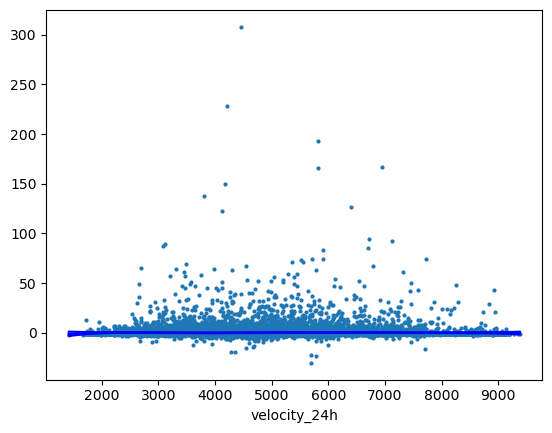

In [49]:
fig = res_bs.plot_partial(0, cpr=True)

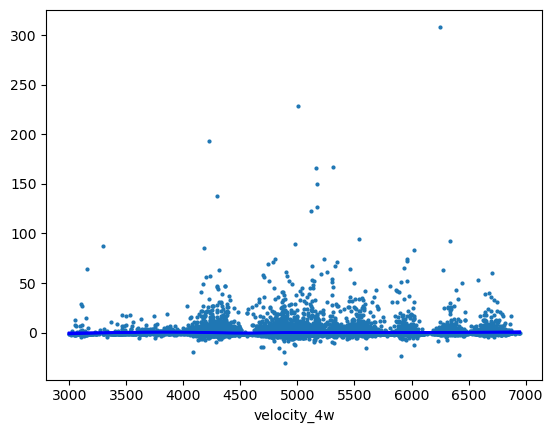

In [50]:
fig = res_bs.plot_partial(1, cpr=True)